In [1]:
import xml.etree.ElementTree as ET
import numpy as np
from pyvi import ViTokenizer, ViPosTagger
from gensim import corpora, matutils, utils
import os
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt
import re
from sklearn.metrics import precision_recall_fscore_support as score

In [2]:
tree = ET.parse('./traindatatopic4.txt')
root = tree.getroot()
root

<Element 'data' at 0x7fbdadf3b890>

In [3]:
SPECIAL_CHARACTER = '0123456789?…“”–•‘’;:~_%@$.,=+-!;></()*"&^:#|\n\t\b\s\''

In [4]:
label = []
content = []
for doc in root.findall('document'):
    label.append(doc.find('label').text)
    content.append(doc.find('content').text)
print(np.shape(label))
print(np.shape(content))

(4962,)
(4962,)


In [5]:
labels = set(label)
# print(labels)
labels = list(labels)
# print(type(labels))
print(labels)

['purchase', 'foreign language', 'sentiment', 'recruit', 'oreign language', 'advertisement', 'other topics']


In [6]:
def get_data():
    data = []
    for i in range(len(label)):
        data.append({
            "label":label[i],
            "content":content[i]
        })
    return data

data = get_data()
len(data)

4962

In [7]:
X_data = []
y_data = []
for text in data:
    xcontent = text['content'].replace('\n', ' ')
    xcontent = utils.simple_preprocess(xcontent)
    xcontent = ' '.join(xcontent)
    xcontent = ViTokenizer.tokenize(unicode(xcontent))
    X_data.append(xcontent)
    y_data.append(text['label'])
# print(X_data)
# print(y_data)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from collections import Counter

In [9]:
# extract features
tfidf_vect = TfidfVectorizer(analyzer='word', max_features=7000)
tfidf_vect.fit(X_data)
X_data_tfidf =  tfidf_vect.transform(X_data)
x_trains = X_data_tfidf.toarray()
print(type(x_trains))
print(np.shape(x_trains))

<type 'numpy.ndarray'>
(4962, 7000)


In [10]:
y_trains = []
for i in range(len(y_data)):
    y_trains.append(labels.index(y_data[i]))
# print(y_trains)
index = y_trains.index(4)
print(index)
del y_trains[index]
y_trains = np.asarray(y_trains)
print(len(y_trains))

x_trains = np.delete(x_trains, index, 0)
print(x_trains.shape)

print(sorted(Counter(y_trains).items()))
# onehot_encoder = OneHotEncoder(sparse=False)
# y_train = y_train.reshape(len(y_train), 1)
# y_train = onehot_encoder.fit_transform(y_train)
# print(type(y_train))
# print(y_train.shape)

1436
4961
(4961, 7000)
[(0, 309), (1, 184), (2, 2550), (3, 189), (5, 1337), (6, 392)]


In [ ]:
###### chia data train thanh train va valid
train_number = np.random.choice(x_trains.shape[0], int(x_trains.shape[0]*0.8), replace=False)
valid_number = np.array(list(set(range(x_trains.shape[0])) - set(train_number)))
print(train_number.shape)
print(valid_number.shape)
x_valid = x_trains[valid_number]
x_trains = x_trains[train_number]
y_valid = y_trains[valid_number]
y_trains = y_trains[train_number]
print(sorted(Counter(y_trains).items()))
## balanced data
ros = RandomOverSampler(random_state=0)
x_train, y_train = ros.fit_sample(x_trains, y_trains)
print(sorted(Counter(y_train).items()))
print('Distribution cua tap valid :', sorted(Counter(y_valid).items()))

keys = []
tmp = [0, 1, 2, 3, 4, 5, 6]
for key, value in sorted(Counter(y_train).items()):
    keys.append(key)
idx_train = list(set(tmp) - set(keys))
print(idx_train)

keys = []
for key, value in sorted(Counter(y_valid).items()):
    keys.append(key)
idx_valid = list(set(tmp) - set(keys))
print(idx_valid)

onehot_encoder = OneHotEncoder(sparse=False)
y_train = y_train.reshape(len(y_train), 1)
y_valids = y_valid
y_valid = y_valid.reshape(len(y_valid), 1)
# print(y_valids)
y_train = onehot_encoder.fit_transform(y_train)
# print(y_valid)
y_valid = onehot_encoder.fit_transform(y_valid)
y_train = np.insert(y_train, idx_train, 0, axis=1)
y_valid = np.insert(y_valid, idx_valid, 0, axis=1)
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(y_valid.shape)

In [12]:
sess = tf.Session()
delta = 1.0
regulation_rate = tf.placeholder(dtype=tf.float32, name='reg')
learning_rate = tf.placeholder(dtype=tf.float32, name='learn')

x_data = tf.placeholder(shape=[None, x_train.shape[1]], dtype=tf.float32, name='x_data')
y_data = tf.placeholder(shape=[None, y_train.shape[1]], dtype=tf.float32, name='y_data')
W = tf.Variable(tf.random_normal(shape=[x_train.shape[1], y_train.shape[1]]), name='W_data')

predict = tf.matmul(x_data, W)
y = tf.reduce_sum(predict * y_data, 1, keep_dims=True)
loss = tf.reduce_mean(tf.reduce_sum(tf.maximum(0.0, delta - y + predict), 1))
loss = tf.add(loss, regulation_rate * tf.nn.l2_loss(W))

prediction = tf.argmax(predict, 1)
accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, tf.argmax(y_data, 1)), tf.float32))

# Declare optimizer 
my_opt = tf.train.AdamOptimizer(learning_rate)
train_step = my_opt.minimize(loss)

In [13]:
batch_size = 64
learning_rates = [0.02, 0.03]
regulation_strengths = [1e-6, 1e-7]
loss_best = 1000
epoch = 100
# del labels[4]
for lr in learning_rates:
    for reg in regulation_strengths:
        sess.run(tf.global_variables_initializer())
        train_loss = []
        valid_loss = []
        pred = []
        train_accuracy = []
        valid_accuracy = []
        for it in range(epoch):
            mix_ids = np.random.permutation(x_train.shape[0])
            n_batchs = int(np.ceil(x_train.shape[0] / float(batch_size)))
            for ib in range(n_batchs):
                rand_index = mix_ids[batch_size*ib:min(batch_size*(ib+1), x_train.shape[0])]
                rand_x = x_train[rand_index]
                rand_y = y_train[rand_index]
                sess.run(train_step, feed_dict={x_data:rand_x, y_data:rand_y, learning_rate:lr, regulation_rate:reg})
                
                tloss = sess.run(loss, feed_dict={x_data:rand_x, y_data:rand_y, regulation_rate:reg})
                train_loss.append(tloss)
                
                train_acc_temp = sess.run(accuracy, feed_dict={x_data:rand_x, y_data:rand_y})
                train_accuracy.append(train_acc_temp)
                
                vloss = sess.run(loss, feed_dict={x_data:x_valid, y_data:y_valid, regulation_rate:reg})
                valid_loss.append(vloss)
                
                
                valid_acc_temp = sess.run(accuracy, feed_dict={x_data:x_valid, y_data:y_valid})
                valid_accuracy.append(valid_acc_temp)
            pred_temp = sess.run(prediction, feed_dict={x_data:x_valid, y_data:y_valid})
            pred.append(pred_temp)    
            if (it % 10 == 0):
                print('epoch: '+str(it)+ ' - Loss_train: '+ str(tloss) +' - Acc_train: ' \
                      + str(train_acc_temp)+' - Loss_valid: '+str(vloss) + ' - Acc_valid: '+str(valid_acc_temp))
        print("Learning_rate: "+str(lr) + " - Regulariation: "+ str(reg) + " - Train_loss: "+ \
                   str(train_loss[-1]) +"- Valid_loss: "+ str(valid_loss[-1])+"\n")
        print(np.shape(y_valids))
        print(np.shape(pred[-1]))
        
        precision, recall, fscore, support = score(y_valids, pred[-1])
        print('\nprecision: {}'.format(precision))
        print('recall: {}'.format(recall))
        print('fscore: {}'.format(fscore))
        print('support: {}'.format(support))
        
        if (valid_loss[-1] < loss_best):
            loss_best = valid_loss[-1]
            W_best = sess.run(W)
            lr_best = lr
            reg_best = reg
            train_loss_best = train_loss
            valid_loss_best = valid_loss
            train_acc_best = train_accuracy
            valid_acc_best = valid_accuracy

epoch: 0 - Loss_train: 1.2050717 - Acc_train: 0.875 - Loss_valid: 2.2146697 - Acc_valid: 0.71601206
epoch: 10 - Loss_train: 1.7633941 - Acc_train: 0.875 - Loss_valid: 1.982458 - Acc_valid: 0.7885196
epoch: 20 - Loss_train: 1.0096155 - Acc_train: 1.0 - Loss_valid: 1.943969 - Acc_valid: 0.7995972
epoch: 30 - Loss_train: 1.0082675 - Acc_train: 1.0 - Loss_valid: 1.9716332 - Acc_valid: 0.7985901
epoch: 40 - Loss_train: 1.0076536 - Acc_train: 1.0 - Loss_valid: 1.968906 - Acc_valid: 0.8207452
epoch: 50 - Loss_train: 1.3215845 - Acc_train: 0.875 - Loss_valid: 1.9733266 - Acc_valid: 0.81369585
epoch: 60 - Loss_train: 1.0074893 - Acc_train: 1.0 - Loss_valid: 1.9278439 - Acc_valid: 0.8036254
epoch: 70 - Loss_train: 1.0075401 - Acc_train: 1.0 - Loss_valid: 1.9761158 - Acc_valid: 0.81772405
epoch: 80 - Loss_train: 1.0073496 - Acc_train: 1.0 - Loss_valid: 2.0021389 - Acc_valid: 0.82376635
epoch: 90 - Loss_train: 1.7575334 - Acc_train: 0.875 - Loss_valid: 1.9685334 - Acc_valid: 0.81168175
Learning_ra

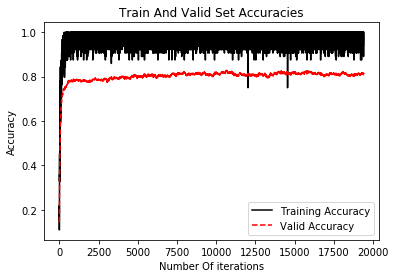

In [14]:
plt.plot(train_acc_best, 'k-', label='Training Accuracy')
plt.plot(valid_acc_best, 'r--', label='Valid Accuracy')
plt.title('Train And Valid Set Accuracies')
plt.xlabel('Number Of iterations')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

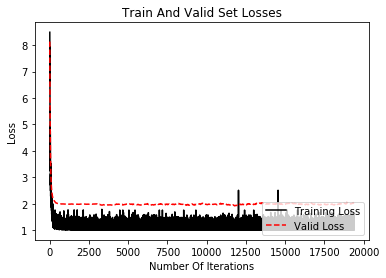

('learning_rate:0.02', 'regulation: 1e-06')


In [15]:
# Plot loss over time
plt.plot(train_loss_best, 'k-',label='Training Loss')
plt.plot(valid_loss_best, 'r--', label='Valid Loss')
plt.title('Train And Valid Set Losses')
plt.xlabel('Number Of Iterations')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()
print("learning_rate:"+str(lr_best),"regulation: "+str(reg_best))